# Least Angle Regression

- 主要实现LARS算法

# 1. Forward-stagewise regression

**Alg**: <br/>
$initialization\ \hat{\mu} = 0$ <br/>
$repeat\ for\ t = 1, 2, 3, ...:$<br/>
$\quad Cal\ current\ correlations\ vector\ \hat{c}$ <br/>
$\quad Pick\ up\ greatest\ current\ correlations\ variable$ <br/>
$\quad Take\ a\ small\ step\ 0 < \epsilon < |c_j|\ in\ the\ direction\ of\ selected\ variable$ <br/>
$\quad \hat{\mu} \leftarrow \hat{\mu} + \epsilon * sign(c_j) * x_j$ <br/>
$until\ none\ of\ the\ variables\ have\ correlation\ with\ the\ residual$

In [1]:
import re
import numpy as np
from sklearn import linear_model
from matplotlib import pyplot as plt

In [2]:
def forward_stagewise_reg(X, y, t=5000, epsilon=3.3):
    mu_hat = np.zeros_like(y)
    w = np.zeros_like(X[0])
    
    while True:
        # cal 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑐𝑜𝑟𝑟𝑒𝑙𝑎𝑡𝑖𝑜𝑛 vector
        C = (X.T).dot(y - mu_hat)
        
        # pick up highest 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑐𝑜𝑟𝑟𝑒𝑙𝑎𝑡𝑖𝑜𝑛 variable
        j = np.argmax(np.abs(C))
        
        # cal step_length
        step_length = epsilon if epsilon < abs(C[j]) else abs(C[j])
        
        # update mu_hat and w
        mu_hat += step_length * np.sign(C[j]) * X[:, j]
        w[j] +=  step_length * np.sign(C[j])
        
        if np.linalg.norm(w, ord=1) > t or np.linalg.norm(C, ord=1) < 1e-6:
            break
    return w

In [3]:
def read_data_from_file(fpath):
    label = []
    data = []
    with open(fpath, 'r') as f:
        label = f.readline().strip().split('\t')
        for line in f:
            data.append(re.split(' |\t', line.strip()))
    data = np.array(data, dtype=np.float64)
    return data, label

In [4]:
data, label = read_data_from_file('diabetes.data')
print(data.shape)
print(data[:5])

(442, 11)
[[ 59.       2.      32.1    101.     157.      93.2     38.       4.
    4.8598  87.     151.    ]
 [ 48.       1.      21.6     87.     183.     103.2     70.       3.
    3.8918  69.      75.    ]
 [ 72.       2.      30.5     93.     156.      93.6     41.       4.
    4.6728  85.     141.    ]
 [ 24.       1.      25.3     84.     198.     131.4     40.       5.
    4.8903  89.     206.    ]
 [ 50.       1.      23.     101.     192.     125.4     52.       4.
    4.2905  80.     135.    ]]


In [5]:
X, y = data[:, :-1], data[:,-1]
X = (X - X.mean(axis=0))
X = X / np.linalg.norm(X, axis=0)
y -= y.mean()
print(X[:5])
print(y[:5])

[[ 0.03807591  0.05068012  0.06169621  0.02187239 -0.0442235  -0.03482076
  -0.04340085 -0.00259226  0.01990749 -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 -0.02632753 -0.00844872 -0.01916334
   0.07441156 -0.03949338 -0.06833155 -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 -0.00567042 -0.04559945 -0.03419447
  -0.03235593 -0.00259226  0.00286131 -0.02593034]
 [-0.08906294 -0.04464164 -0.01159501 -0.03665608  0.01219057  0.02499059
  -0.03603757  0.03430886  0.02268774 -0.00936191]
 [ 0.00538306 -0.04464164 -0.03638469  0.02187239  0.00393485  0.01559614
   0.00814208 -0.00259226 -0.03198764 -0.04664087]]
[ -1.13348416 -77.13348416 -11.13348416  53.86651584 -17.13348416]


In [6]:
print('OLS: ', (np.linalg.inv((X.T).dot(X))).dot(X.T).dot(y))

OLS:  [ -10.0098663  -239.81564367  519.84592005  324.3846455  -792.17563855
  476.73902101  101.04326794  177.06323767  751.27369956   67.62669218]


In [7]:
forward_stagewise_reg(X ,y, t=3460)

array([ -10.00986617, -239.81564348,  519.84592049,  324.38464525,
       -792.17561537,  476.73900289,  101.04325735,  177.06323414,
        751.27369086,   67.62669233])

In [8]:
ts = np.linspace(0, 3460, 100)
coefs = []

for t in ts:
    w = forward_stagewise_reg(X ,y, t=t)
    coefs.append(w)
coefs = np.array(coefs)

(-173.0, 3633.0, -869.3480806781228, 828.4461561688399)

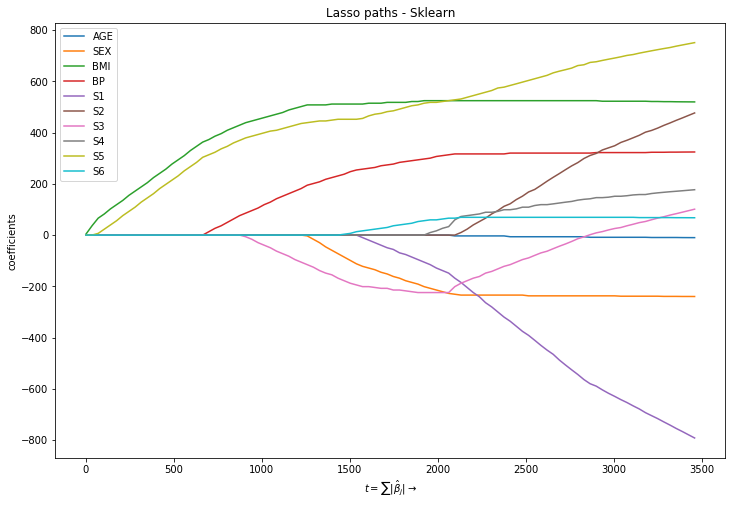

In [9]:
plt.figure(figsize = (12,8))
for i in range(10):
    plt.plot(ts, coefs[:,i], label=label[i])

plt.ylabel('coefficients')
plt.xlabel('$t=\sum|\hat{\\beta}_j| \\rightarrow $')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

## 2. LARS

**Alg**: <br/>
$initialization\ \hat{\mu} = 0$ <br/>
$repeat\ t = 1,2,...,m:$<br/>
$\quad Cal\ current\ correlations\ vector\ \hat{c}$ <br/>
$\quad Cal\ X_{\cal A},A_{\cal A},u_{\cal A}\ and\ a$ <br/>
$\quad updates\ \hat{\mu}_{\cal A}: \hat{\mu}_{\cal A_+} = \hat{\mu}_{\cal A} + \hat{\gamma} u_{\cal A},$ <br/>

In [10]:
def lars_reg(X, y):
    m = X.shape[1]
    mu_hat = np.zeros_like(y)
    w = np.zeros_like(X[0])
    
    for i in range(m):
        # get residual with lars estimate mu_hat
        residual = y - mu_hat
        
        # cal current correlations vector
        c_hat = (X.T).dot(residual)
        C_hat = np.max(np.abs(c_hat))      # max correlations
        
        # active set
        A = set(np.where(np.isclose(np.abs(c_hat), C_hat))[0])
 
        X_A = X[:, sorted(list(A))]*np.sign(c_hat[sorted(list(A))])
        G_A = (X_A.T).dot(X_A)
        G_A_inv = np.linalg.inv(G_A)
    
        A_A = (np.ones((1, len(A))).dot(G_A_inv).dot(np.ones(len(A))))**(-.5)
        
        w_A = A_A*G_A_inv.dot(np.ones(len(A)))
        u_A = X_A.dot(w_A)   # equiangular vector
        
        a = (X.T).dot(u_A)
        
        # start cal step length: gamma_hat
        tmp = [(C_hat-c_hat[j])/(A_A-a[j])  for j in range(m) if j not in A]
        tmp.extend([(C_hat+c_hat[j])/(A_A+a[j])  for j in range(m) if j not in A])
        
        gamma_hat = C_hat/A_A if len(tmp)==0 else np.min([e for e in tmp if e > 0])
        
        mu_hat += gamma_hat*u_A
        w[sorted(list(A))] += gamma_hat*w_A*np.sign(c_hat[sorted(list(A))])
        
        if len(tmp) == 0: break
    return w

In [11]:
lars_reg(X, y)

array([ -10.0098663 , -239.81564367,  519.84592005,  324.3846455 ,
       -792.17563855,  476.73902101,  101.04326794,  177.06323767,
        751.27369956,   67.62669218])

## 参考：
- Forward-stagewise regression: LeastAngle_2002.pdf 或者 'The Elements of Statistical Learning' p60
- LARS: LeastAngle_2002.pdf 及 'The Elements of Statistical Learning' p73